# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

### Split the data into train val, and test set (starified)

In [109]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


In [117]:
import os, glob, random
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


from torch.utils.data import WeightedRandomSampler
import numpy as np


from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms





In [111]:
DATA_DIR = "/kaggle/input/horse-breeds"
all_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.png")))
print("Total images:", len(all_paths))
print([os.path.basename(p) for p in all_paths[:10]])


Total images: 670
['01_001.png', '01_002.png', '01_003.png', '01_004.png', '01_005.png', '01_006.png', '01_007.png', '01_008.png', '01_009.png', '01_010.png']


In [ ]:
all_paths = sorted([os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR)])

labels = [f.split("_")[0] for f in os.listdir(DATA_DIR)]

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

val_paths, test_paths, _, _ = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)



### Dataset Class

In [113]:

PREFIX_TO_BREED = {
    "01": "Akhal-Teke",
    "02": "Appaloosa",
    "03": "Orlov Trotter",
    "04": "Vladimir Heavy Draft",
    "05": "Percheron",
    "06": "Arabian",
    "07": "Friesian",
}

PREFIX_TO_IDX = {k: i for i, k in enumerate(sorted(PREFIX_TO_BREED.keys()))}
IDX_TO_BREED = {PREFIX_TO_IDX[k]: v for k, v in PREFIX_TO_BREED.items()}
NUM_CLASSES = len(PREFIX_TO_BREED)
print("Number of classes:", NUM_CLASSES)


Number of classes: 7


In [114]:
class HorseDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        image = Image.open(path).convert("RGB")
        label = PREFIX_TO_IDX[os.path.basename(path).split("_")[0]]
        if self.transform:
            image = self.transform(image)
        return image, label



### Transform


In [119]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


val_test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


### Create Dataloader objects

In [120]:
BATCH_SIZE = 32

train_dataset = HorseDataset(train_paths, train_transform)
val_dataset   = HorseDataset(val_paths,   val_test_transform)
test_dataset  = HorseDataset(test_paths,  val_test_transform)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Num batches:", len(train_loader), len(val_loader), len(test_loader))


Num batches: 15 4 4


#### Display some images

In [121]:
import torch

def denormalize(tensor, mean, std):

    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean


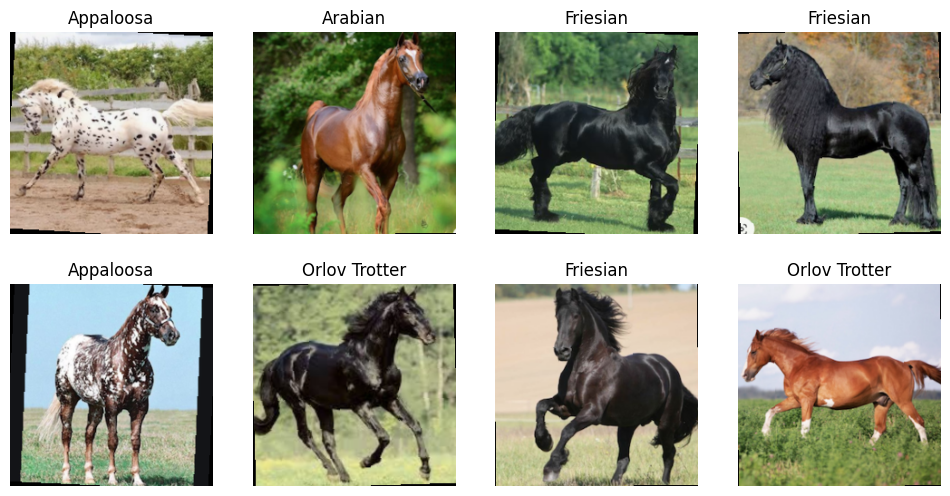

In [122]:
def show_samples(dataset, n=8):
    
    n = min(n, len(dataset))
    idxs = random.sample(range(len(dataset)), n)

    cols = 4
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    axes = axes.flatten()

    for ax_i, idx in enumerate(idxs):
        img, y = dataset[idx]  
        img_denorm = denormalize(img, IMAGENET_MEAN, IMAGENET_STD)
        img_np = img_denorm.permute(1, 2, 0).numpy()

        axes[ax_i].imshow(img_np)
        axes[ax_i].set_title(IDX_TO_BREED[y])
        axes[ax_i].axis("off")

    for j in range(ax_i + 1, len(axes)):
        axes[j].axis("off")

    plt.show()

show_samples(train_dataset, n=8)


### Define Model 

### Model 1: CNN from scratch

In [123]:
model_cnn = SimpleCNN(num_classes=7, dropout_p=0.3).to(device)


### Model 2: Transfer Learning

In [124]:
model_tl = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for p in model_tl.parameters():
    p.requires_grad = False

model_tl.fc = nn.Linear(model_tl.fc.in_features, 7)
model_tl = model_tl.to(device)


### define Loss and Optimizer

In [125]:
loss_function_cnn = nn.CrossEntropyLoss()
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

loss_function_tl = nn.CrossEntropyLoss()
optimizer_tl = optim.Adam(model_tl.fc.parameters(), lr=1e-3, weight_decay=1e-4)


#### Build one_epoch_training function loop 

In [126]:
def one_epoch_training(model, dataloader, loss_function, optimizer, device):

    model.train()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = loss_function(logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        predictions = torch.argmax(logits, dim=1)
        total_correct += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


#### Build one_epoch_validation function loop 

In [127]:
def one_epoch_validation(model, dataloader, loss_function, device):
    
    model.eval()

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = loss_function(logits, labels)

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)
            total_correct += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_correct / total_samples

    return avg_loss, avg_acc


In [128]:
train_loss, train_acc = one_epoch_training(model_tl, train_loader, loss_function_tl, optimizer_tl, device)
val_loss, val_acc = one_epoch_validation(model_tl, val_loader, loss_function_tl, device)

print("Train:", train_loss, train_acc)
print("Val:  ", val_loss, val_acc)


Train: 1.8872268279393514 0.2579957356076759
Val:   1.595155507326126 0.34


### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


In [136]:
history_cnn = training_loop(
    model_cnn, train_loader, val_loader,
    loss_function_cnn, optimizer_cnn,
    device, epochs=15, save_path="best_model_cnn.pth"
)

history_tl = training_loop(
    model_tl, train_loader, val_loader,
    loss_function_tl, optimizer_tl,
    device, epochs=15, save_path="best_model_tl.pth"
)



Epoch 01: train_loss=0.8593, train_acc=0.6397 | val_loss=1.1323, val_acc=0.6000 | best_val_acc=0.6000
Epoch 02: train_loss=0.8796, train_acc=0.6567 | val_loss=1.1258, val_acc=0.6000 | best_val_acc=0.6000
Epoch 03: train_loss=0.8474, train_acc=0.6802 | val_loss=0.9646, val_acc=0.6500 | best_val_acc=0.6500
Epoch 04: train_loss=0.8199, train_acc=0.6823 | val_loss=1.1024, val_acc=0.6200 | best_val_acc=0.6500
Epoch 05: train_loss=0.8282, train_acc=0.6908 | val_loss=0.9178, val_acc=0.7100 | best_val_acc=0.7100
Epoch 06: train_loss=0.7447, train_acc=0.7015 | val_loss=1.0250, val_acc=0.6700 | best_val_acc=0.7100
Epoch 07: train_loss=0.7340, train_acc=0.7058 | val_loss=1.0066, val_acc=0.6300 | best_val_acc=0.7100
Epoch 08: train_loss=0.7362, train_acc=0.7249 | val_loss=0.9118, val_acc=0.6500 | best_val_acc=0.7100
Epoch 09: train_loss=0.6877, train_acc=0.7441 | val_loss=1.1599, val_acc=0.6500 | best_val_acc=0.7100
Epoch 10: train_loss=0.6045, train_acc=0.7676 | val_loss=0.9860, val_acc=0.6300 | 

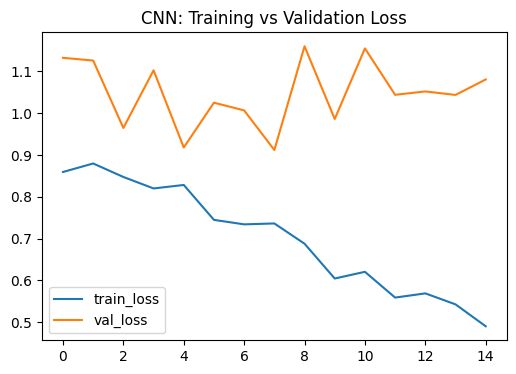

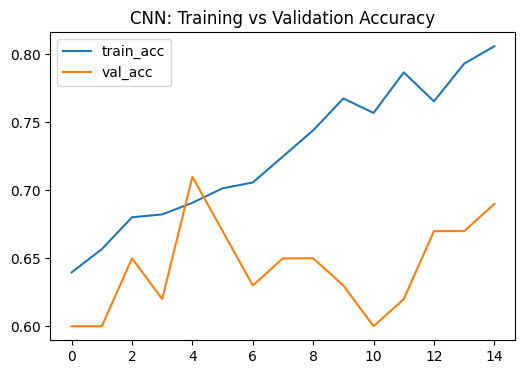

In [137]:
plt.figure(figsize=(6,4))
plt.plot(history_cnn["train_loss"], label="train_loss")
plt.plot(history_cnn["val_loss"], label="val_loss")
plt.legend()
plt.title("CNN: Training vs Validation Loss")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history_cnn["train_acc"], label="train_acc")
plt.plot(history_cnn["val_acc"], label="val_acc")
plt.legend()
plt.title("CNN: Training vs Validation Accuracy")
plt.show()


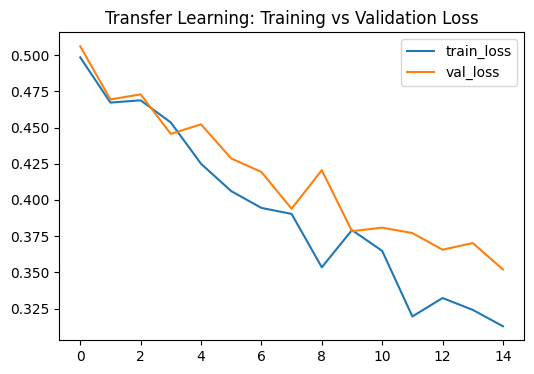

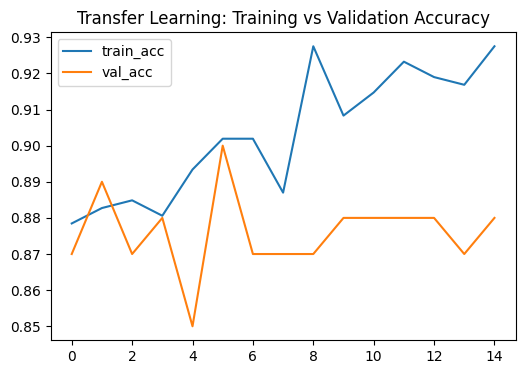

In [138]:
plt.figure(figsize=(6,4))
plt.plot(history_tl["train_loss"], label="train_loss")
plt.plot(history_tl["val_loss"], label="val_loss")
plt.legend()
plt.title("Transfer Learning: Training vs Validation Loss")
plt.show()


plt.figure(figsize=(6,4))
plt.plot(history_tl["train_acc"], label="train_acc")
plt.plot(history_tl["val_acc"], label="val_acc")
plt.legend()
plt.title("Transfer Learning: Training vs Validation Accuracy")
plt.show()


### test the model on test set

In [139]:
best_model_tl = models.resnet18(weights=None)
best_model_tl.fc = nn.Linear(best_model_tl.fc.in_features, 7)
best_model_tl.load_state_dict(torch.load("best_model_tl.pth", map_location=device))
best_model_tl.to(device).eval()

test_loss, test_acc = one_epoch_validation(
    best_model_tl, test_loader, loss_function_tl, device
)

print("Transfer Learning Test accuracy:", test_acc)


Transfer Learning Test accuracy: 0.7425742574257426


### show some predictions with the images

In [140]:
def show_predictions(model, loader, idx_to_name, device, n_images=8, title="Predictions"):
    model.eval()

    images, labels = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)

    images = images.cpu()
    labels = labels.cpu()
    preds  = preds.cpu()

    n = min(n_images, images.shape[0])
    cols = 4
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()

        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        true_name = idx_to_name[int(labels[i])]
        pred_name = idx_to_name[int(preds[i])]

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"T: {true_name}\nP: {pred_name}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()



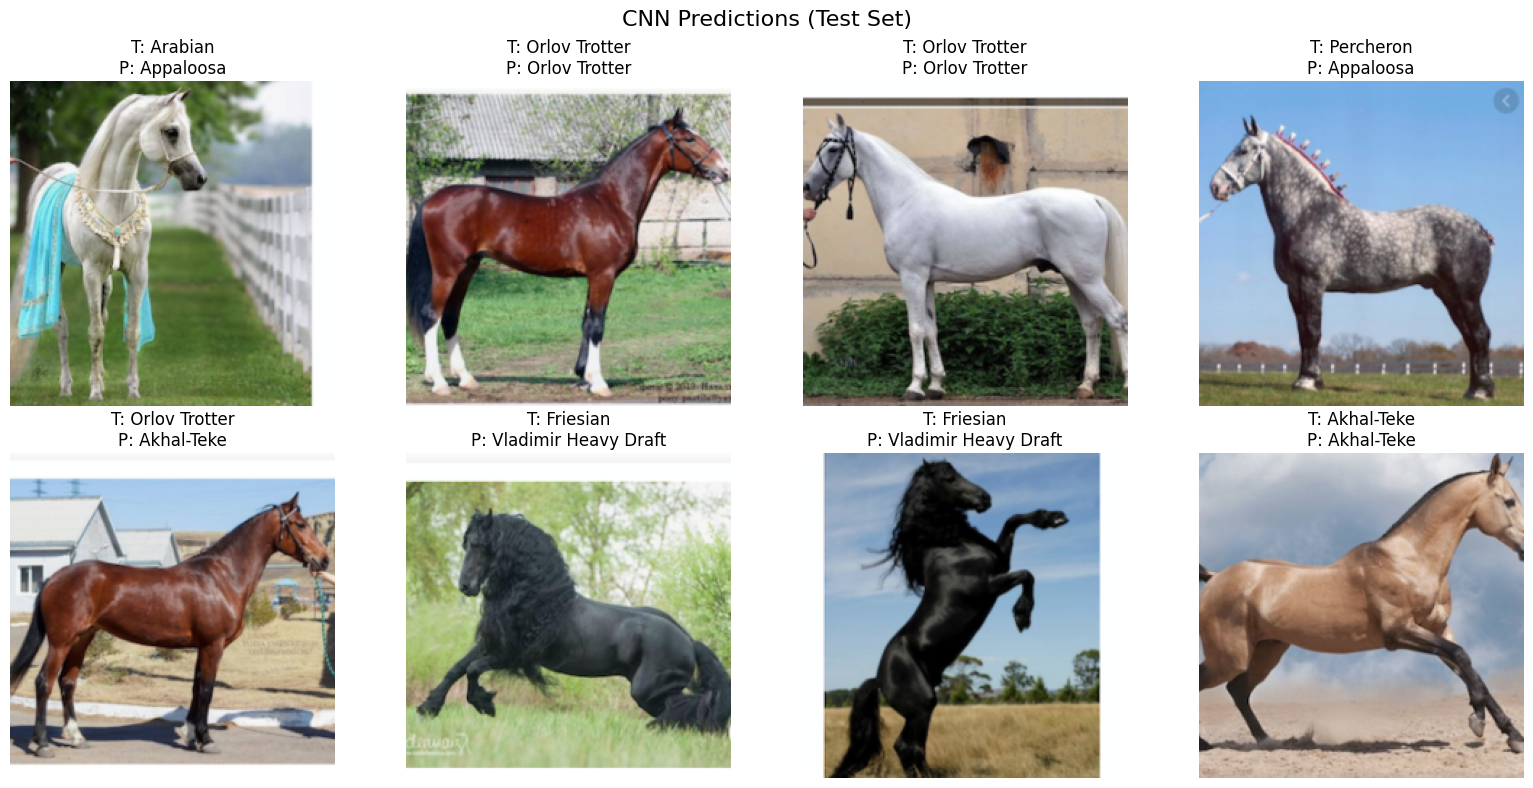

In [141]:
show_predictions(
    model=best_model_cnn,
    loader=test_loader,
    idx_to_name=IDX_TO_BREED,
    device=device,
    n_images=8,
    title="CNN Predictions (Test Set)"
)



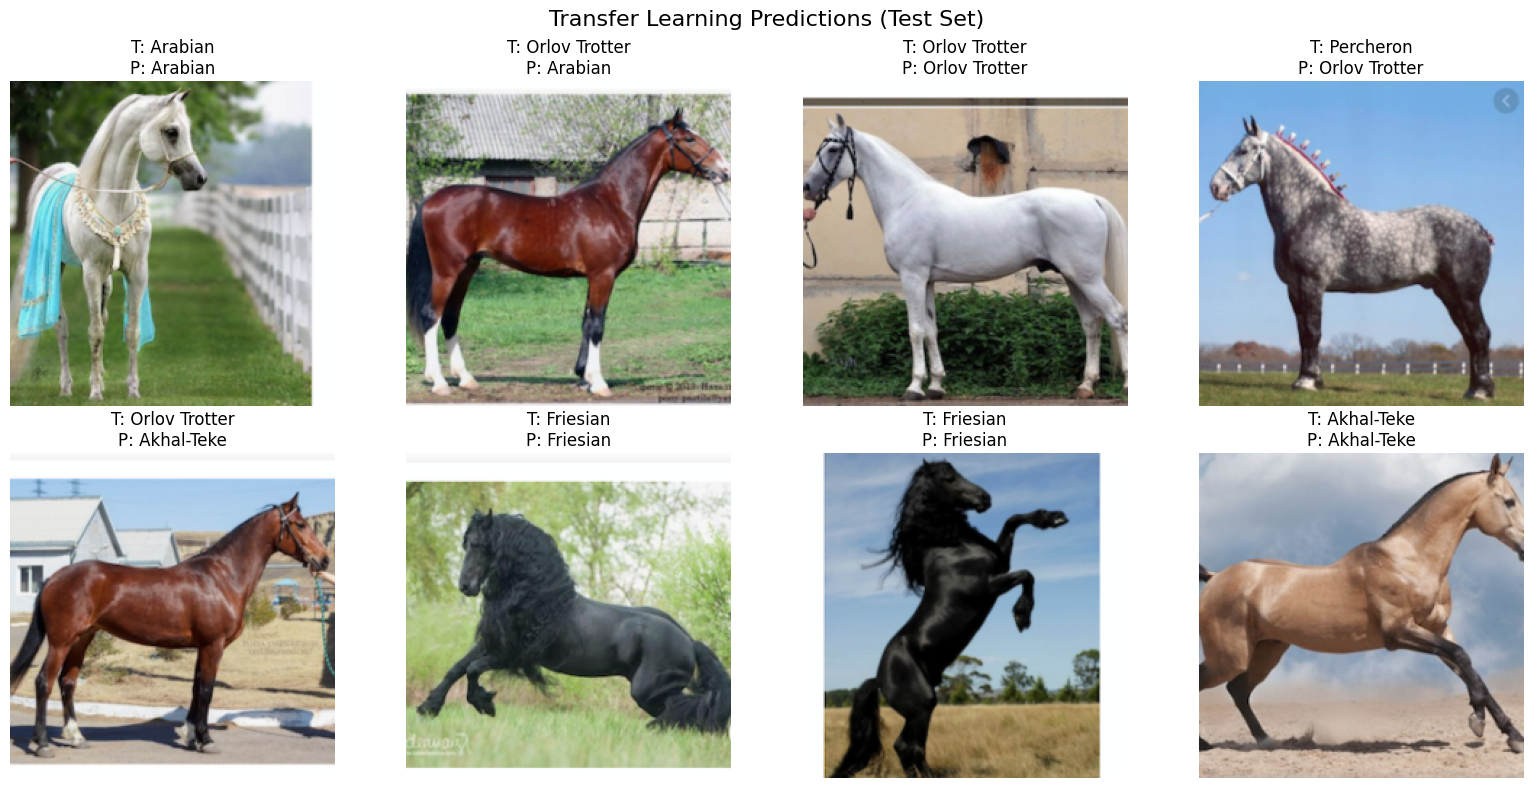

In [142]:
show_predictions(
    model=best_model_tl,
    loader=test_loader,
    idx_to_name=IDX_TO_BREED,
    device=device,
    n_images=8,
    title="Transfer Learning Predictions (Test Set)"
)


### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

 The CNN model trained from scratch achieved relatively low accuracy due to the limited dataset size and the visual similarity between horse breeds. This indicates that the model struggled to learn strong features from the data alone.

In contrast, the transfer learning model based on a pretrained ResNet18 achieved better performance, with a test accuracy of around 75%. This shows that transfer learning is more effective for this task.

The training and validation curves did not show a large gap, indicating that the model is not severely overfitting. Overall, transfer learning provided better generalization compared to the CNN model.